<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/chords_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y gensim

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [3]:
pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [4]:
pip install pyLDAvis

In [5]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

In [8]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-02 14:01:09--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.102, 74.125.195.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/59m89i5a4g4egkou583s0qlf5kftqc4l/1635861600000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-02 14:01:10--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/59m89i5a4g4egkou583s0qlf5kftqc4l/1635861600000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-d

Download the file with the meta data from Google Drive:

In [9]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-02 14:01:10--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 74.125.135.100, 74.125.135.138, 74.125.135.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m5p8sijc072omohnkhvn4g7g15kk5mff/1635861600000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-02 14:01:11--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m5p8sijc072omohnkhvn4g7g15kk5mff/1635861600000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-d

### Chords Data

In [10]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [11]:
data = [line.split(' ') for line in lines]

### Meta Data

In [12]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.head(5)

,id,file_name,title,composer,year,year_truncated,tonality,tune_key,tune_mode,structure,num_bars,time_signature,cycle_fifths_order,style,musicbrainz_id,wikidata_id,wikidata_allmusic,wiki_link,wikidata_description,lyricist
0,0,dataset/jazz1350/26-2.xml,26-2,John Coltrane,1960.0,1960.0,F major,F,major,AABA,32.0,4/4,-1.0,Medium Up Swing,eb51f0dd-c9a6-3849-b135-9cfaa7a90396,NaN,NaN,NaN,NaN,NaN
1,1,dataset/jazz1350/500 Miles High.xml,500 Miles High,Chick Corea,1978.0,1978.0,E minor,E,minor,NaN,26.0,4/4,1.0,Bossa Nova,1e03810a-6632-35ee-959b-dfd244be19b5,NaN,NaN,NaN,NaN,Neville Potter
2,2,dataset/jazz1350/502 Blues.xml,502 Blues,Jimmy Rowles,1962.0,1962.0,A minor,A,minor,NaN,32.0,3/4,0.0,Waltz,cff33fd3-7be2-3559-b06a-1d5cee201939,NaN,NaN,NaN,NaN,NaN
3,3,dataset/jazz1350/52nd Street Theme.xml,52nd Street Theme,Thelonious Monk,1944.0,1944.0,C major,C,major,AABA,32.0,4/4,0.0,Up Tempo Swing,aaa19faf-298a-3e89-9599-6a30866cd7fd,NaN,NaN,NaN,NaN,NaN
4,4,dataset/jazz1350/9.20 Special.xml,9.20 Special,Earle Warren,1941.0,1941.0,C major,C,major,AABA,32.0,4/4,0.0,Medium Swing,67755649-b89e-409c-ad6b-488f4cd455a5,Q16824165,NaN,https://en.wikipedia.org/wiki/9:20_Special,1941 song,William Engvick


In [13]:
titles = meta.loc[:, ['id', 'title']].drop_duplicates()
titles.set_index('id', inplace=True)
titles

,title
id,
0,26-2
1,500 Miles High
2,502 Blues
3,52nd Street Theme
4,9.20 Special
...,...
2048,You're Foolin' Someone
2049,You're Lucky To Me
2050,You're Nobody Till Somebody Loves You


In [14]:
from gensim.test.utils import common_texts
import gensim.models as models
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
id2word = corpora.Dictionary(data)

2021-11-02 14:01:13,891 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-02 14:01:13,893 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
2021-11-02 14:01:13,899 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)", 'datetime': '2021-11-02T14:01:13.899267', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-02 14:01:13,976 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-02 14:01:14,051 : INFO : built Dictionary(159 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7', 'Bm7']...) from 2046 documents (total 93630 corpus positions)
2021-11-02 14:01:14,052 : INFO : Dictionary lifecycle event {'msg': "b

In [15]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data]

In [94]:
# Train the model on the corpus.
#lda = models.LdaModel(common_corpus, num_topics=10)
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           #update_every=1,
                                           #chunksize=10,
                                           #passes=10,
                                           alpha='symmetric',
                                           #iterations=100,
                                           per_word_topics=True)

2021-11-02 14:43:52,844 : INFO : using symmetric alpha at 0.06666666666666667
2021-11-02 14:43:52,850 : INFO : using symmetric eta at 0.06666666666666667
2021-11-02 14:43:52,856 : INFO : using serial LDA version on this node
2021-11-02 14:43:52,859 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 2046 documents, updating model once every 2000 documents, evaluating perplexity every 2046 documents, iterating 50x with a convergence threshold of 0.001000
2021-11-02 14:43:52,861 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-11-02 14:43:52,864 : INFO : PROGRESS: pass 0, at document #2000/2046
2021-11-02 14:43:54,089 : INFO : merging changes from 2000 documents into a model of 2046 documents
2021-11-02 14:43:54,091 : INFO : topic #3 (0.067): 0.079*"Am" + 0.059*"Am6" + 0.053*"C7" + 0.052*"G7" + 0.050*"E7" + 0.047*"A7" + 0.044*"Am7" + 0.041*"F7" + 0.040*

In [95]:
lda_model.print_topics()

2021-11-02 14:43:54,251 : INFO : topic #0 (0.067): 0.294*"G" + 0.192*"D7" + 0.057*"E7" + 0.055*"CM7" + 0.054*"C" + 0.050*"G7" + 0.035*"A" + 0.027*"B7" + 0.026*"A7" + 0.022*"Am7"
2021-11-02 14:43:54,255 : INFO : topic #1 (0.067): 0.152*"Dm7" + 0.130*"G7" + 0.080*"A7" + 0.064*"C6" + 0.062*"E7" + 0.053*"CM7" + 0.044*"D7" + 0.043*"Am7" + 0.041*"Em7" + 0.029*"Am"
2021-11-02 14:43:54,259 : INFO : topic #2 (0.067): 0.087*"Em7" + 0.080*"C7" + 0.069*"CM7" + 0.062*"Bb7" + 0.056*"Dm7" + 0.054*"F7" + 0.053*"G7" + 0.042*"A7" + 0.042*"C#7" + 0.036*"B7"
2021-11-02 14:43:54,262 : INFO : topic #3 (0.067): 0.308*"Am" + 0.191*"E7" + 0.062*"A7" + 0.052*"G7" + 0.039*"B7" + 0.023*"C7" + 0.023*"Am7" + 0.022*"C" + 0.022*"Am6" + 0.021*"D7"
2021-11-02 14:43:54,265 : INFO : topic #4 (0.067): 0.152*"C7" + 0.089*"F" + 0.076*"G7" + 0.062*"F7" + 0.050*"Am7" + 0.038*"Dm7" + 0.038*"C#7" + 0.027*"G#7" + 0.024*"Bb" + 0.022*"CM7"
2021-11-02 14:43:54,267 : INFO : topic #5 (0.067): 0.122*"CM7" + 0.119*"G7" + 0.083*"Dm7" + 

[(0,
  '0.294*"G" + 0.192*"D7" + 0.057*"E7" + 0.055*"CM7" + 0.054*"C" + 0.050*"G7" + 0.035*"A" + 0.027*"B7" + 0.026*"A7" + 0.022*"Am7"'),
 (1,
  '0.152*"Dm7" + 0.130*"G7" + 0.080*"A7" + 0.064*"C6" + 0.062*"E7" + 0.053*"CM7" + 0.044*"D7" + 0.043*"Am7" + 0.041*"Em7" + 0.029*"Am"'),
 (2,
  '0.087*"Em7" + 0.080*"C7" + 0.069*"CM7" + 0.062*"Bb7" + 0.056*"Dm7" + 0.054*"F7" + 0.053*"G7" + 0.042*"A7" + 0.042*"C#7" + 0.036*"B7"'),
 (3,
  '0.308*"Am" + 0.191*"E7" + 0.062*"A7" + 0.052*"G7" + 0.039*"B7" + 0.023*"C7" + 0.023*"Am7" + 0.022*"C" + 0.022*"Am6" + 0.021*"D7"'),
 (4,
  '0.152*"C7" + 0.089*"F" + 0.076*"G7" + 0.062*"F7" + 0.050*"Am7" + 0.038*"Dm7" + 0.038*"C#7" + 0.027*"G#7" + 0.024*"Bb" + 0.022*"CM7"'),
 (5,
  '0.122*"CM7" + 0.119*"G7" + 0.083*"Dm7" + 0.045*"Am7" + 0.044*"A7" + 0.042*"Fm7" + 0.040*"Em7" + 0.029*"Bb7" + 0.028*"F7" + 0.028*"C7"'),
 (6,
  '0.143*"CM7" + 0.081*"Dm7" + 0.048*"G7" + 0.046*"Em7" + 0.045*"D7" + 0.044*"Eb7" + 0.042*"C#7" + 0.034*"A7" + 0.032*"C6" + 0.032*"C7"'),
 (7

In [96]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  #max_words=10,
                  colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=15, num_words=50, formatted=False)
len(topics)

15

Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

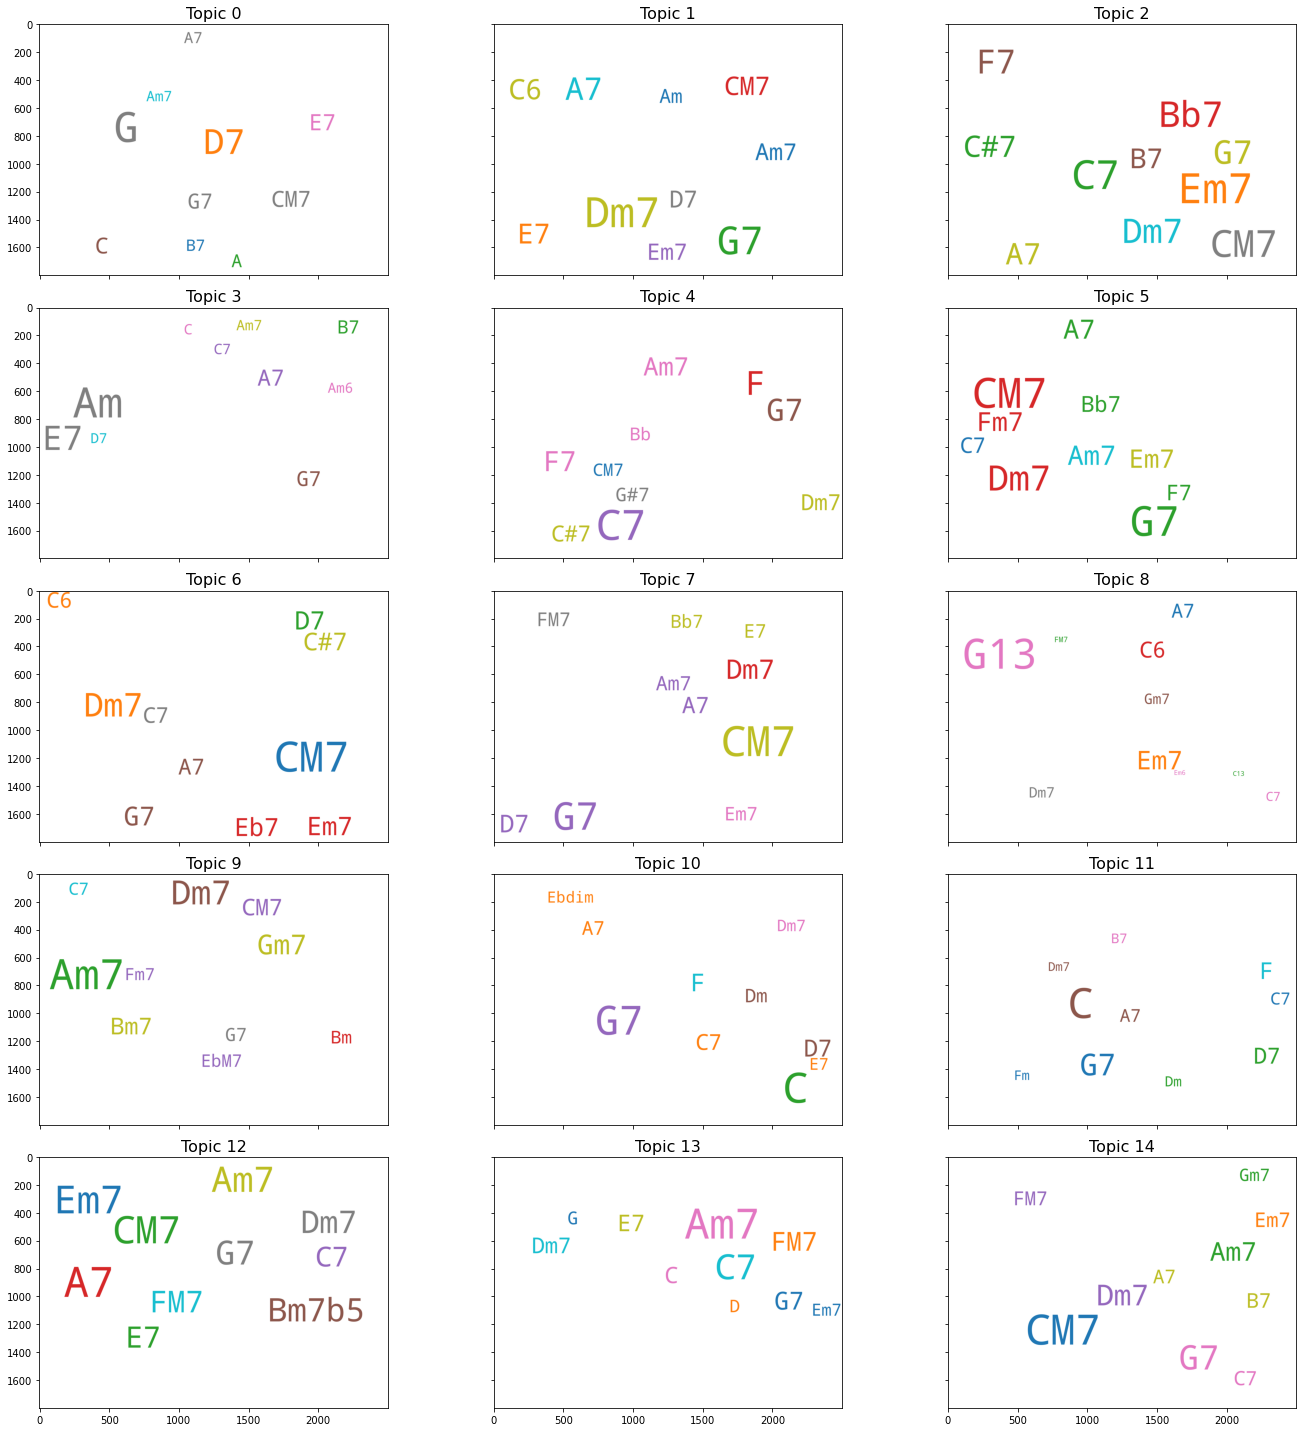

In [101]:
fig, axes = plt.subplots(5, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    #plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

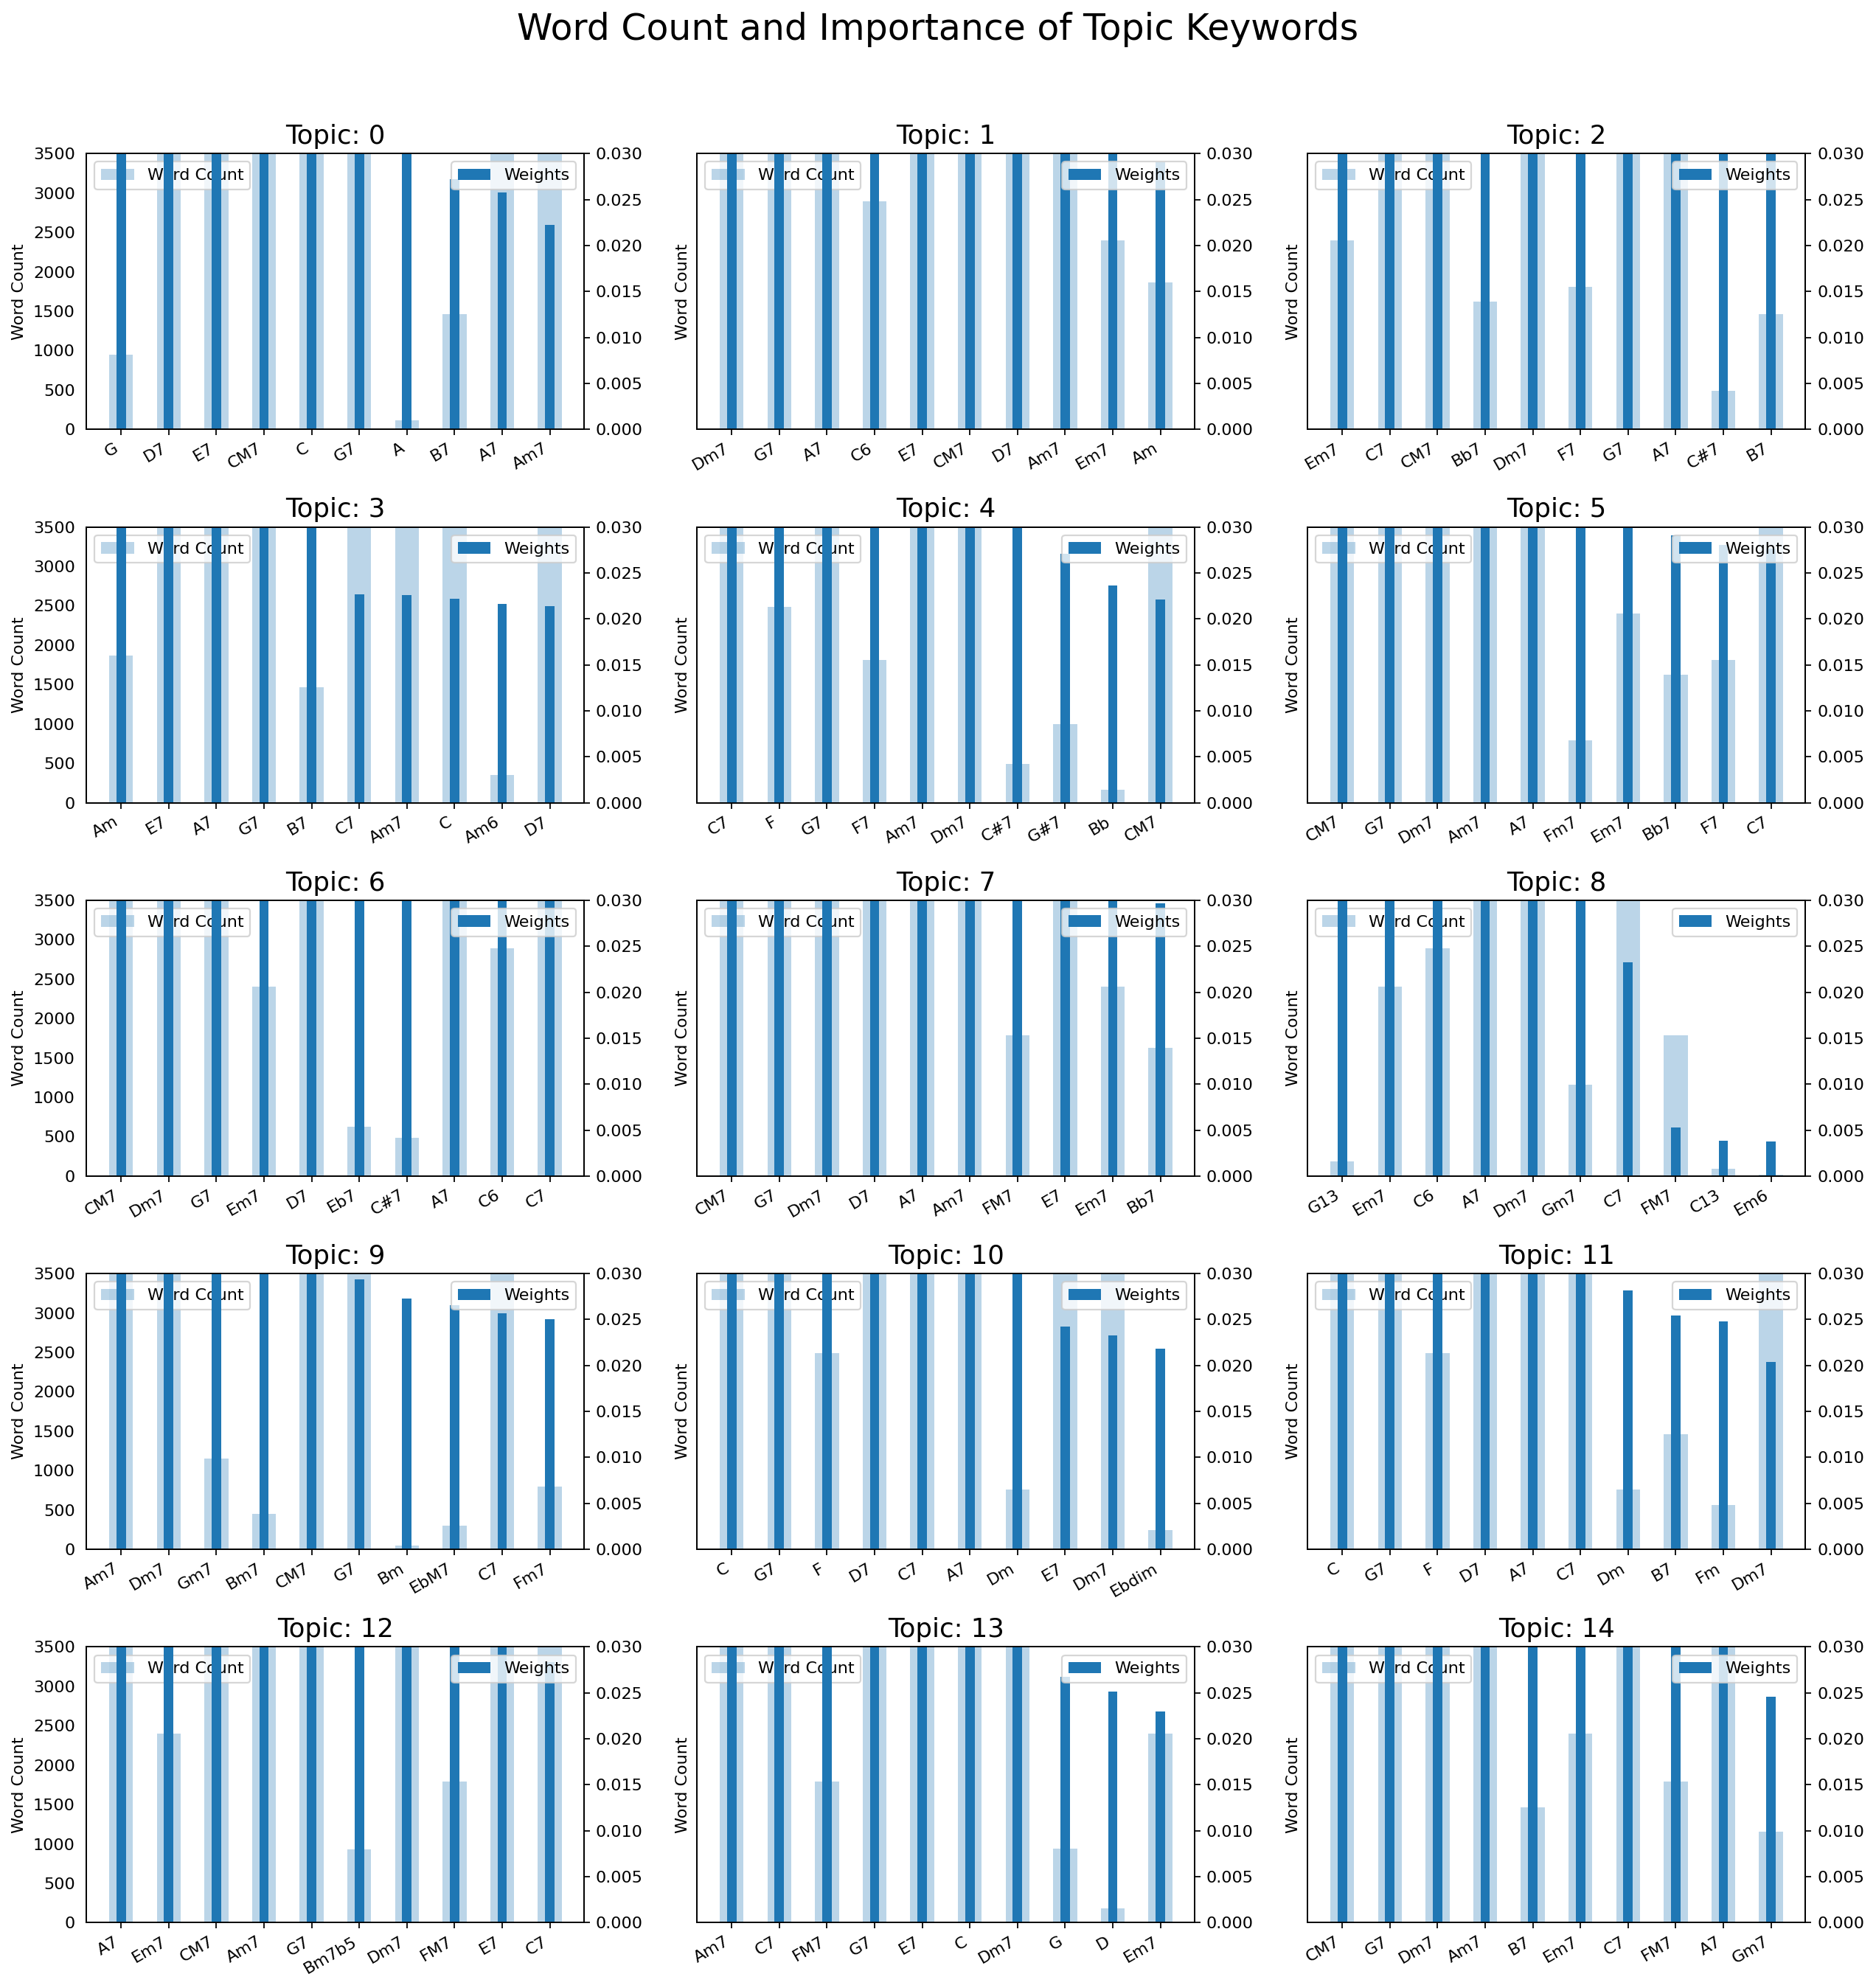

In [100]:
from collections import Counter
topics = lda_model.show_topics(num_topics=15, num_words=10, formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 3, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", 
           data=df.loc[df.topic_id==i, :], 
           #color=cols[i], 
           width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], 
                #color=cols[i], 
                width=0.2, label='Weights')
    ax.set_ylabel('Word Count')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [91]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [92]:
df_dominant_topic_in_each_doc

,Dominant_Topic,count
0,0,13
1,1,526
2,2,40
3,3,90
4,4,78
5,5,39
6,6,100
7,7,206
8,8,1
9,9,40


In [88]:
topic_top3words

[(0, 'G'),
 (0, 'D7'),
 (0, 'C'),
 (7, 'CM7'),
 (7, 'G7'),
 (7, 'Dm7'),
 (15, 'D7'),
 (15, 'CM7'),
 (15, 'G7'),
 (5, 'G7'),
 (5, 'CM7'),
 (5, 'Dm7'),
 (6, 'CM7'),
 (6, 'Dm7'),
 (6, 'G7'),
 (10, 'C'),
 (10, 'G7'),
 (10, 'F'),
 (14, 'CM7'),
 (14, 'G7'),
 (14, 'Dm7'),
 (12, 'Am7'),
 (12, 'Em7'),
 (12, 'CM7'),
 (4, 'C7'),
 (4, 'G7'),
 (4, 'F7'),
 (3, 'Am'),
 (3, 'E7'),
 (3, 'A7')]

In [90]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

IndexError: ignored

<Figure size 1200x480 with 2 Axes>